In [1]:
import pandas as pd
import csv
import numpy as np
import string
import spacy
import ftfy
import contractions
import json
import nltk
import re
import transformers

## Preprocess

In [2]:
contraction_map={
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "might have",
    "mustn't": "must not",
    "needn't": "need not",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "shall'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there would",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "will't've": "will not have",
    "would've": "would have",
    "would't": "would not",
    "y'all": "you all",
    "y'all'd": "you all would",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

def expand_contractions(sent, mapping):
    #pattern for matching contraction with their expansions
    pattern = re.compile('({})'.format('|'.join(mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    
    def expand_map(contraction):
        #using group method to access subgroups of the match
        match = contraction.group(0)
        #to retain correct case of the word
        first_char = match[0]
        #find out the expansion
        expansion = mapping.get(match) if mapping.get(match) else mapping.get(match.lower())
        expansion = first_char + expansion[1:]
        return expansion
    
    #using sub method to replace all contractions with their expansions for a sentence
    #function expand_map will be called for every non overlapping occurence of the pattern
    expand_sent = pattern.sub(expand_map, sent)
    return expand_sent

In [3]:
def preprocess_data(datapath):
    file = open(f"{datapath}", 'r')
    texts = file.readlines()
    dictionary = dict()
    
    for line in texts:
        fields = json.loads(line)
        # remove empty articles
        if fields["text"]:
            text_data = fields["text"]
            # impute encodings
            text_data = ftfy.fix_text(text_data)#.replace('\n', ' ')
            # expand contractions
            text_data = expand_contractions(text_data, contraction_map)
            # remove punctuations
            text_data = text_data.translate(str.maketrans('', '', string.punctuation))

            dictionary[fields["id"]] = text_data
    
    return dictionary

In [4]:
d = preprocess_data("C:/Users/Sverre/Documents/UNI/2amm30/enwiki20220701-stripped/enwiki20220701-stripped/AA/wiki_00")

In [2]:
#d['12']

In [6]:
# # very slow
# # lemmatization: use only tagger to speed up
# nlp = spacy.load("en_core_web_sm",  disable=["parser", "ner"])

# for key in d:
#     doc = nlp(d[key])
#     text_data = ' '.join([token.lemma_ for token in doc])
#     d[key] = text_data

# # ALSO SLOW:

# from nltk.stem import WordNetLemmatizer
# wn_lemmatizer = WordNetLemmatizer()

# for key in d:
#     text_data = d[key]
#     d[key] = " ".join([wn_lemmatizer.lemmatize(w) for w in text_data])

In [7]:
import pickle

filename = 'wiki_00'
#C:/Users/Sverre/Documents/UNI/2amm30/2AMM30-TextMining
rootpath = "C:/Users/Sverre/Documents/UNI/2amm30/2AMM30-TextMining/local_storage"

file_string = f"{rootpath}/preprocessed_file_{filename}"
with open(file_string, 'wb') as f:
    pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)

## REBEL

In [8]:
import requests
import re
import hashlib
from spacy import Language
from typing import List

from spacy.tokens import Doc, Span

from transformers import pipeline

def call_wiki_api(item):
    try:
        url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={item}&language=en&format=json"
        data = requests.get(url).json()
        # Return the first id (Could upgrade this in the future)
        return data['search'][0]['id']
    except:
        return 'id-less'

def extract_triplets(text):
    """
    Function to parse the generated text and extract the triplets
    """
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})

    return triplets


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)
        self.entity_mapping = {}
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
            Doc.set_extension("rel", default={})

    def get_wiki_id(self, item: str):
        mapping = self.entity_mapping.get(item)
        if mapping:
            return mapping
        else:
            res = call_wiki_api(item)
            self.entity_mapping[item] = res
            return res

    
    def _generate_triplets(self, sent: Span) -> List[dict]:
        output_ids = self.triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]["output_ids"]
        extracted_text = self.triplet_extractor.tokenizer.batch_decode(output_ids[0])
        extracted_triplets = extract_triplets(extracted_text[0])
        return extracted_triplets

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        for triplet in triplets:

            # Remove self-loops (relationships that start and end at the entity)
            if triplet['head'] == triplet['tail']:
                continue

            # Use regex to search for entities
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)

            # Skip the relation if both head and tail entities are not present in the text
            # Sometimes the Rebel model hallucinates some entities
            if not head_span or not tail_span:
                continue

            index = hashlib.sha1("".join([triplet['head'], triplet['tail'], triplet['type']]).encode('utf-8')).hexdigest()
            if index not in doc._.rel:
                # Get wiki ids and store results
                doc._.rel[index] = {"relation": triplet["type"], "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(triplet['tail'])}}

    def __call__(self, doc: Doc) -> Doc:
        for sent in doc.sents:
            sentence_triplets = self._generate_triplets(sent)
            self.set_annotations(doc, sentence_triplets)
        return doc

In [10]:
import crosslingual_coreference

DEVICE = -1 # Number of the GPU, -1 if want to use CPU

# Add coreference resolution model
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": DEVICE})

# Define rel extraction model

rel_ext = spacy.load('en_core_web_sm', disable=['ner', 'lemmatizer', 'attribute_rules', 'tagger'])
rel_ext.add_pipe("rebel", config={
    'device':DEVICE, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )

models/crosslingual-coreference/minilm/model.tar.gz: 358490KB [00:08, 41490.48KB/s]                            
error loading _jsonnet (this is expected on Windows), treating C:\Users\Sverre\AppData\Local\Temp\tmpv8r0pqca\config.json as plain json
Downloading: 100%|██████████| 489/489 [00:00<00:00, 244kB/s]
Downloading: 100%|██████████| 4.83M/4.83M [00:00<00:00, 5.96MB/s]
Downloading: 100%|██████████| 8.66M/8.66M [00:01<00:00, 8.17MB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 79.7kB/s]
Downloading: 100%|██████████| 225M/225M [00:06<00:00, 36.4MB/s] 
Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertFo

In [1]:
#d.keys()

This REBEL model implementation suffers from being quite slow. On article ID 586 it is extremely slow and on article ID 12 it throws an error.
This is likely due to the length of the texts being very long. In order to fix this we can do the following:
- Downscale each article to paragraph and/or sentence level.
- Filter on the whole set of articles to limit the overall lengths on all articles to some maximum number of words/characters.

In [21]:
# fails on d['12'] most likely due to lenght of the text
# quite slow.... on d['586']
input_text = d['307']

coref_text = coref(input_text)._.resolved_text

doc = rel_ext(coref_text)

for value, rel_dict in doc._.rel.items():
    print(f"{value}: {rel_dict}")

KeyboardInterrupt: 

## NLTK

Some limitations encountered through the NLTK modeling:
- The relation extraction is limited based on extract_rels subject and object class, which focuses on very standard instances like PERSON, ORGANIZATION and DATE. This implies that there is quite a strong limit on what kind of articles we can talk about.
- extract_rels requires us to specify a pattern for which it aims to find relations, in order to extract many types of relations they must then satisfy two things: 1. the relation is portrayed using a specific pattern and 2. all desires relations must be described through some pattern.

Some possible benefits:
- The word tokenization as well as the pos_tagging (and even the NE_chunk) components are all separate, meaning it may be possible to adapt the pipeline constructed this way to fit different types of pos_tagging, NE_chunking and tokenization to create a variety of pipelines with possibly different behaviors and accuracies.

In [22]:
# download the pos tagger since its not included by default
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

# enable only if fresh NLTK or lots of issues
#nltk.download('all')

#pip install svgling

In [23]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.sem.relextract import extract_rels

In [42]:
te = d['307'].splitlines()
use = te[1]
use

'Lincoln was born into poverty in a log cabin in Kentucky and was raised on the frontier primarily in Indiana He was selfeducated and became a lawyer Whig Party leader Illinois state legislator and US Congressman from Illinois In 1849 he returned to his law practice but became vexed by the opening of additional lands to slavery as a result of the Kansas–Nebraska Act of 1854 He reentered politics in 1854 becoming a leader in the new Republican Party and he reached a national audience in the 1858 Senate campaign debates against Stephen Douglas Lincoln ran for President in 1860 sweeping the North to gain victory Proslavery elements in the South viewed his election as a threat to slavery and Southern states began seceding from the Union During this time the newly formed Confederate States of America began seizing federal military bases in the south Just over one month after Lincoln assumed the presidency the Confederate States attacked Fort Sumter a US fort in South Carolina Following the 

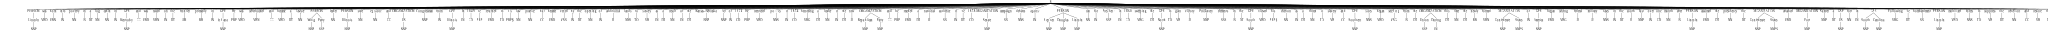

In [43]:
# tokenize sentence
#use = "Humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires."
token = word_tokenize(use)
# pos_tag sentence
pos = pos_tag(token)
#pos
# chunk sentence
chunked = ne_chunk(pos)
chunked

In [44]:
import re
#(any of 'LOCATION', 'ORGANIZATION', 'PERSON', 'DURATION', 'DATE', 'CARDINAL', 'PERCENT', 'MONEY', 'MEASURE')
rels = extract_rels('PERSON', 'GPE', chunked, corpus='ace', pattern=re.compile(r'.*\bborn\b.*'), window = 100)
rels

[defaultdict(str,
             {'lcon': '',
              'subjclass': 'PERSON',
              'subjtext': 'Lincoln/NNP',
              'subjsym': 'lincoln',
              'filler': 'was/VBD born/VBN into/IN poverty/NN in/IN a/DT log/NN cabin/NN in/IN',
              'untagged_filler': 'was born into poverty in a log cabin in',
              'objclass': 'GPE',
              'objtext': 'Kentucky/NNP',
              'objsym': 'kentucky',
              'rcon': 'and/CC was/VBD raised/VBN on/IN the/DT'})]

## NER using BERT model

In [27]:
# NER step using BERT
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

Downloading: 100%|██████████| 59.0/59.0 [00:00<00:00, 29.5kB/s]
Downloading: 100%|██████████| 829/829 [00:00<00:00, 827kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 744kB/s] 
Downloading: 100%|██████████| 2.00/2.00 [00:00<00:00, 999B/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 112kB/s]
Downloading: 100%|██████████| 413M/413M [00:11<00:00, 38.6MB/s] 


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


## Evaluation of models

Initially the plan for the model evaluation was to annotate a set of articles such that we indicated the relations desired in the article. Then by running the article through each pipeline we would get a list of relations found. Evaluation would then consist of cross referencing between the found list from the pipeline and the desired list manually created. Based on the above pipelines, it may be required to downscale this significantly for example by:
- Limiting the size of the article to sentence/paragraph based.
- Limiting the set of relations sought after to a set of standard or simple relations.

For the purpose of closed KE, which the 2 constructed pipelines entail, evaluation would simple be tracking whether all possible relations were found and an accuracy can be computed based on this.
For the purpose on open RE, manual crossreferencing may be required.